In [1]:
# Author : Evangelos Papoutsellis
# Contact : http://epapoutsellis.github.io/

### SIRF subsets : New functionality

- Requires [subset_object](https://github.com/SyneRBI/SIRF/tree/subset_object) from SIRF and
```pet.AcquisitionData.set_storage_scheme("memory")```
 - It uses the new functionality of KullbackLeibler function class. [WIP](https://github.com/TomographicImaging/CIL/pull/1272).
 - It uses `AcquisitionModelUsingParallelproj`.

In [2]:
#%% Initial imports etc
import numpy
import matplotlib.pyplot as plt

import os
import sys
import shutil
import sirf

import sirf.STIR as pet
from sirf.Utilities import examples_data_path

# turn off verbosity
pet.set_verbosity(0)
pet.AcquisitionData.set_storage_scheme("memory")
msg = sirf.STIR.MessageRedirector(info=None, warn=None, errr=None)

# cil imports
from cil.plugins.ccpi_regularisation.functions import FGP_TV    
from cil.optimisation.functions import KullbackLeibler, IndicatorBox, OperatorCompositionFunction, L2NormSquared, BlockFunction, TotalVariation
from cil.optimisation.operators import BlockOperator
from cil.optimisation.algorithms import SPDHG, PDHG, FISTA   
from cil.utilities.display import show2D

# problem with "check input method" `geometry` attribute does not exist in SIRF
def new_check_input(self, input):
    pass

FGP_TV.check_input = new_check_input

In [3]:
# define the directory with input files for this notebook
data_path = os.path.join(examples_data_path('PET'), 'thorax_single_slice')

In [4]:
#%% some handy function definitions
def plot_2d_image(idx,vol,title,clims=None,cmap="viridis"):
    """Customized version of subplot to plot 2D image"""
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar(shrink=.4)
    plt.title(title)
    plt.axis("off")

def make_positive(image_array):
    """truncate any negatives to zero"""
    image_array[image_array<0] = 0
    return image_array

def make_cylindrical_FOV(image):
    """truncate to cylindrical FOV"""
    filter = pet.TruncateToCylinderProcessor()
    filter.apply(image)

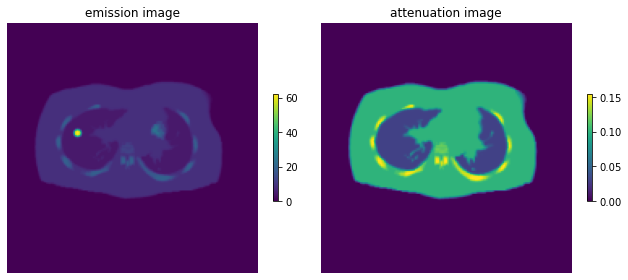

In [5]:
#%% Read in images
image = pet.ImageData(os.path.join(data_path, 'emission.hv'))
attn_image = pet.ImageData(os.path.join(data_path, 'attenuation.hv'))
template = pet.AcquisitionData(os.path.join(data_path, 'template_sinogram.hs'))

#%% display
im_slice = image.dimensions()[0]//2
plt.figure(figsize=(9, 4))
plot_2d_image([1,2,1],image.as_array()[im_slice,:,:,], 'emission image')
plot_2d_image([1,2,2],attn_image.as_array()[im_slice,:,:,], 'attenuation image')
plt.tight_layout()

In [6]:
# create attenuation
acq_model_for_attn = pet.AcquisitionModelUsingParallelproj()
asm_attn = pet.AcquisitionSensitivityModel(attn_image, acq_model_for_attn)
asm_attn.set_up(template)
attn_factors = asm_attn.forward(template.get_uniform_copy(1))
asm_attn = pet.AcquisitionSensitivityModel(attn_factors)

In [7]:
# create acquisition model
acq_model = pet.AcquisitionModelUsingParallelproj()
# we will increase the number of rays used for every Line-of-Response (LOR) as an example
# (it is not required for the exercise of course)
acq_model.set_acquisition_sensitivity(asm_attn)
# set-up
acq_model.set_up(template,image)

In [8]:
#%% simulate some data using forward projection
acquired_data = acq_model.forward(image)

In [9]:
# # let's add a background term of a reasonable scale
background_term = acquired_data.get_uniform_copy(acquired_data.max()/10)

# acq_model.set_background_term(background_term)
# acquired_data = acq_model.forward(image)

### Solve with PDHG (use of proximal conjugate of KullbackLeibler)

In [10]:
alpha = 0.1
F = KullbackLeibler(b=acquired_data, eta = background_term, backend="numba")
G = alpha * FGP_TV() #IndicatorBox(lower=0)
operator = acq_model

normK = operator.norm()
sigma = 0.001
tau = 1.0/(sigma * normK**2)

pdhg = PDHG(f = F, g = G, operator = operator, max_iteration=200, 
            update_objective_interval=50, sigma=sigma, tau=tau)
pdhg.run(verbose=2)

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        200         0.000    5.12602e+05  -0.00000e+00    5.12602e+05
       50        200         5.952    9.69736e+04   8.43272e+04    1.26465e+04
      100        200         6.125    9.67467e+04   5.58713e+03    9.11596e+04
      150        200         6.083    9.67155e+04   5.47419e+03    9.12413e+04
      200        200         6.057    9.67043e+04   5.41774e+03    9.12865e+04
----------------------------------------------------------------------------
      200        200         6.057    9.67043e+04   5.41774e+03    9.12865e+04
Stop criterion has been reached.



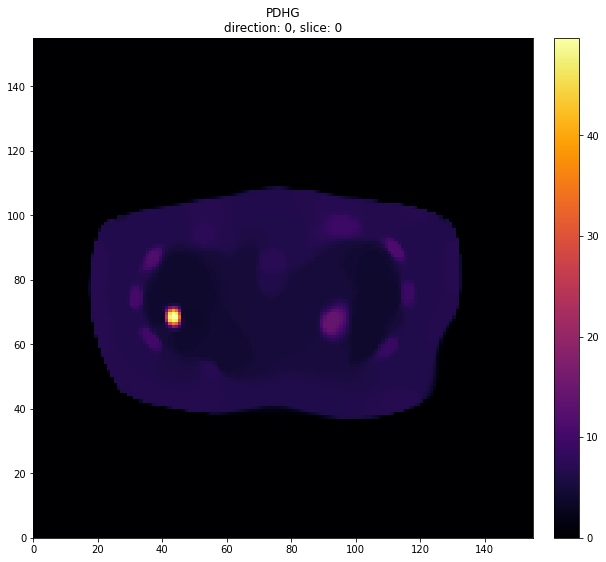

In [11]:
show2D(pdhg.solution, cmap="inferno", title="PDHG")

### Solve with FISTA (use of gradient of KullbackLeibler)

Choose a value for the Lipshitz constant (`F.L`) of `KullbackLeibler`, because it is `None` by default.
This is similar to selecting the step_size for ISTA/FISTA. In the new implementation (under review) there is a `step_size` argument. Alternatively, we can use `SmoothKullbackLeibler` (wip).

In [12]:
# Solve with FISTA
initial = image.get_uniform_copy(0)

alpha = 0.1
F = KullbackLeibler(b=acquired_data, eta = background_term, backend="numba") 
# use numba = False does not work

F.L = 0.001
G = alpha * FGP_TV() #IndicatorBox(lower=0)
F_fista = OperatorCompositionFunction(F, acq_model)

fista = FISTA(initial = initial, f = F_fista, g=G, update_objective_interval=50,
                            max_iteration=200)
fista.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          5.12602e+05
       50        200         6.066          1.37582e+05
      100        200         6.103          9.67134e+04
      150        200         6.084          9.66931e+04
      200        200         6.062          9.66926e+04
-------------------------------------------------------
      200        200         6.062          9.66926e+04
Stop criterion has been reached.



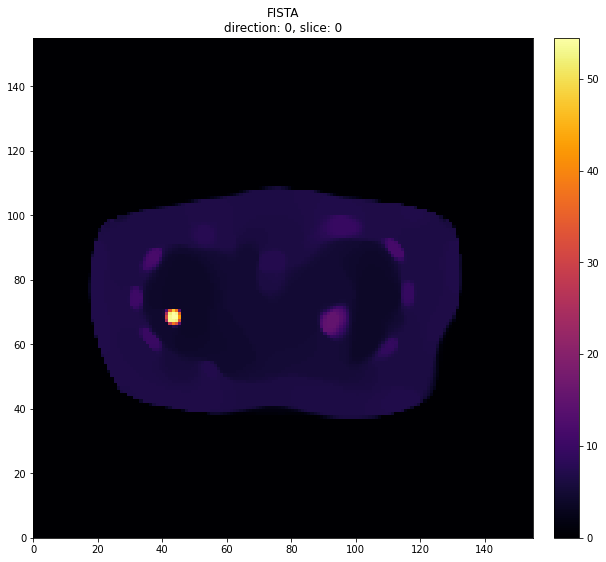

In [13]:
show2D(fista.solution, cmap="inferno", title = "FISTA")

### Solve with SPDHG (use of proximal conjugate of KullbackLeibler and the subsets functionality of SIRF)

In [14]:
n_subsets = 8

dim = acquired_data.dimensions()
print('data dimensions: %d x %d x %d x %d' % dim) 

f_subsets = []
A_subsets = []

for i in range(n_subsets):
    
    views = numpy.arange(i, dim[2], n_subsets)
    
    data_subset = acquired_data.get_subset(views)
    print(views,'\n', data_subset.shape)
    eta_sirf = background_term.get_subset(views) # background is constant atm
    
    fi = KullbackLeibler(b = data_subset, eta = eta_sirf, backend = "numba") 
    f_subsets.append(fi)
    
    # confirm next lines with Kris/Evgueni
    acq_model = pet.AcquisitionModelUsingParallelproj()
    asm_attn = pet.AcquisitionSensitivityModel(attn_factors.get_subset(views)) 
    acq_model.set_acquisition_sensitivity(asm_attn)
    acq_model.set_up(data_subset,image)  
                
    A_subsets.append(acq_model)
        
# Define F and K
F = BlockFunction(*f_subsets)
K = BlockOperator(*A_subsets)

data dimensions: 1 x 1 x 64 x 192
[ 0  8 16 24 32 40 48 56] 
 (1, 1, 8, 192)
[ 1  9 17 25 33 41 49 57] 
 (1, 1, 8, 192)
[ 2 10 18 26 34 42 50 58] 
 (1, 1, 8, 192)
[ 3 11 19 27 35 43 51 59] 
 (1, 1, 8, 192)
[ 4 12 20 28 36 44 52 60] 
 (1, 1, 8, 192)
[ 5 13 21 29 37 45 53 61] 
 (1, 1, 8, 192)
[ 6 14 22 30 38 46 54 62] 
 (1, 1, 8, 192)
[ 7 15 23 31 39 47 55 63] 
 (1, 1, 8, 192)


In [15]:
tmp_norms = [i.norm() for i in K.operators]
print(*(i for i in tmp_norms), sep='\n')

19.044654846191406
19.04681968688965
19.0622615814209
19.0803279876709
19.086944580078125
19.07431983947754
19.056169509887695
19.046995162963867


In [16]:
# Setup and run SPDHG 
spdhg = SPDHG(f = F, g = G, operator = K,  max_iteration = n_subsets*100,
            update_objective_interval = 50, gamma=0.1)
spdhg.run(verbose = 2)


     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        800         0.000    5.12602e+05  -0.00000e+00    5.12602e+05
       50        800         5.899    9.68214e+04   5.53475e+04    4.14739e+04
      100        800         5.957    9.67169e+04   3.28434e+04    6.38735e+04
      150        800         6.028    9.66974e+04   5.35807e+03    9.13393e+04
      200        800         6.014    9.66947e+04   5.34920e+03    9.13455e+04
      250        800         6.011    9.66937e+04   5.34306e+03    9.13506e+04
      300        800         5.414    9.66931e+04   5.33886e+03    9.13543e+04
      350        800         4.918    9.66929e+04   5.33638e+03    9.13565e+04
      400        800         4.510    9.66927e+04   5.33447e+03    9.13583e+04
      450        800         4.218    9.66927e+04   5.33304e+03    9.13596e+04
      500        800         3.958    9.66926e+04   

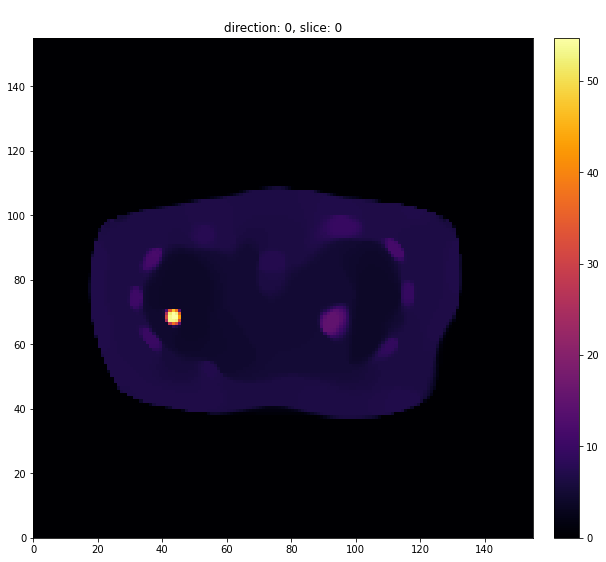

In [17]:
show2D(spdhg.solution, cmap="inferno")

In [18]:
print(" Objective PDHG = {} ".format(pdhg.objective[-1]))
print(" Objective FISTA = {} ".format(fista.objective[-1]))
print(" Objective SPDHG = {} ".format(spdhg.objective[-1]))     

 Objective PDHG = 96704.25151634216 
 Objective FISTA = 96692.642121315 
 Objective SPDHG = 96692.5707359314 


### Compare old vs new functionality

In [19]:
print( "Image data = {} ".format(image.shape))
print( "Acquisition data = {} ".format(acquired_data.shape))

n_subsets = 8

dim = acquired_data.dimensions()

A_subsets = []

for i in range(n_subsets):
    
    views = numpy.arange(i, dim[2], n_subsets)
    
    data_subset = acquired_data.get_subset(views)
    
    acq_model = pet.AcquisitionModelUsingParallelproj()
    asm_attn = pet.AcquisitionSensitivityModel(attn_factors.get_subset(views)) 
    acq_model.set_acquisition_sensitivity(asm_attn)
    acq_model.set_up(data_subset,image)  
                
    A_subsets.append(acq_model)
    
K = BlockOperator(*A_subsets)

for i in range(n_subsets):
    
    print(" Direct of a subset acquisition model " )
    res_new = K[i].direct(image)
    print( " Shape of acquisition data subset = {} \n".format(res_new.shape))

    views = numpy.arange(i, dim[2], n_subsets)
    res_old = res_new * 0.0
    res_old.fill(acquired_data.as_array()[:,:,views,:])
    
    numpy.testing.assert_allclose(res_new.as_array(), res_old.as_array())

Image data = (1, 155, 155) 
Acquisition data = (1, 1, 64, 192) 
 Direct of a subset acquisition model 
 Shape of acquisition data subset = (1, 1, 8, 192) 

 Direct of a subset acquisition model 
 Shape of acquisition data subset = (1, 1, 8, 192) 

 Direct of a subset acquisition model 
 Shape of acquisition data subset = (1, 1, 8, 192) 

 Direct of a subset acquisition model 
 Shape of acquisition data subset = (1, 1, 8, 192) 

 Direct of a subset acquisition model 
 Shape of acquisition data subset = (1, 1, 8, 192) 

 Direct of a subset acquisition model 
 Shape of acquisition data subset = (1, 1, 8, 192) 

 Direct of a subset acquisition model 
 Shape of acquisition data subset = (1, 1, 8, 192) 

 Direct of a subset acquisition model 
 Shape of acquisition data subset = (1, 1, 8, 192) 



### Time comparison

In [20]:
# create attenuation
acq_model_for_attn = pet.AcquisitionModelUsingParallelproj()
asm_attn = pet.AcquisitionSensitivityModel(attn_image, acq_model_for_attn)
asm_attn.set_up(template)
attn_factors = asm_attn.forward(template.get_uniform_copy(1))
asm_attn = pet.AcquisitionSensitivityModel(attn_factors)

acq_model_old = pet.AcquisitionModelUsingParallelproj()
acq_model_old.set_acquisition_sensitivity(asm_attn)
acq_model_old.set_up(template, image)

In [21]:
%timeit res_old = acq_model_old.direct(image)

22.2 ms ± 561 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%timeit res_new = K[0].direct(image)

17.9 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%timeit res_new = K[1].direct(image)

13.3 ms ± 2.37 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%timeit res_new = K[2].direct(image)

15.4 ms ± 3.34 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
